# Applied Statistics -  Assesment Problems

This notebook contains my solutions to the **Applied Statistics** assessment problems.  
It is designed for an informed computing professional (e.g. a prospective employer or lecturer) who:

- is comfortable with Python and numerical computing, but  
- may not be familiar with the specific libraries, functions, or statistical techniques used.

Each problem follows a consistent structure:

- **Plan & References** – what is being done and why, with links to relevant documentation.  
- **Simulation / Analysis** – well-commented code using NumPy, SciPy, pandas, and Matplotlib.  
- **Interpretation** – a short narrative explaining the results in statistical terms.

The focus is on:

- **Reproducibility** – fixed random seeds and clear setup.  
- **Clarity** – small, well-named code blocks and succinct comments.  
- **Statistical insight** – interpreting simulations in terms of hypotheses, error rates, and model assumptions.

Run the notebook from top to bottom to reproduce all calculations, plots, and tables.

In [1]:
# === Setup & imports ===
import math # for mathematical functions
import itertools # for combinatorial functions
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
from scipy import stats # for statistical functions
import statsmodels.api as sm # for statistical models (e.g., regression)
import statsmodels.formula.api as smf # for formula interface

# Prefer the new Generator API
SEED = 42 # for reproducibility
rng = np.random.default_rng(SEED)  

# Plot defaults (readable fonts and grid)
plt.rcParams.update({
    'figure.figsize': (8, 4),
    'axes.grid': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

print(f"Environment initialised. numpy={np.__version__}, pandas={pd.__version__}")


Environment initialised. numpy=1.26.4, pandas=2.3.2


## Problem 1 — Extending the Lady Tasting Tea


### Plan & References

- **Null model:** participant guesses by choosing exactly the milk-first positions uniformly at random.
- **Exact probability:** a perfect guess matches the true subset of indices, so 
  $\Pr(\text{all correct}) = 1/\binom{n_{\text{total}}}{n_{\text{milk}}}$ using `math.comb`
  ([Python docs](https://docs.python.org/3/library/math.html#math.comb)).
- **Simulation:** use the modern NumPy random Generator API
  ([NumPy RNG docs](https://numpy.org/doc/stable/reference/random/generator.html)) to repeatedly choose subsets.
- **Partial matches (optional):** the number of correctly guessed milk cups follows a hypergeometric distribution
  ([scipy.stats.hypergeom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html)), which we compute explicitly via combinations for transparency.  

In [2]:
# --- Problem 1: Extending the Lady Tasting Tea ---------------------------------------------
# References:
# - Combinations: https://docs.python.org/3/library/math.html#math.comb
# - NumPy Generator (rng): https://numpy.org/doc/stable/reference/random/generator.html
# - Hypergeometric (concept): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html
# - Hypergeometric (scipy): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html

import math
from random import seed
import numpy as np
import pandas as pd

# Use a fixed seed for reproducibility (assessment requirement)
SEED = 42 
rng = np.random.default_rng(SEED)

def p_all_correct_exact(n_total: int, n_milk: int) -> float:
    """
    Exact probability of a perfect identification under random guessing.
    Rationale: the guess is a uniformly random subset of size n_milk.
    There is exactly 1 correct subset out of C(n_total, n_milk) possibilities.
    """ # Use math.comb for combinations
    return 1.0 / math.comb(n_total, n_milk)

def p_all_correct_sim(n_total: int, n_milk: int, trials: int = 300_000, seed: int = SEED) -> float:
    """
    Monte Carlo estimate under the null: fix one random ground-truth set of milk indices, 
    sample a guess of size n_milk, and check whether it matches exactly.
    """ # Use a local RNG for reproducibility
    rng = np.random.default_rng(seed)
    true_milk = set(rng.choice(n_total, size=n_milk, replace=False))
    hits = 0
    for _ in range(trials):
        guess = set(rng.choice(n_total, size=n_milk, replace=False))
        if guess == true_milk:
            hits += 1
    return hits / trials

designs = [
    {"label": "Classic (8 cups; 4 milk-first)",  "n_total": 8,  "n_milk": 4},
    {"label": "Extended (12 cups; 4 milk-first)", "n_total": 12, "n_milk": 4},
]

rows = []
for d in designs:
    pe = p_all_correct_exact(d["n_total"], d["n_milk"])  # exact probability
    ps = p_all_correct_sim(d["n_total"], d["n_milk"], trials=300_000)  # simulation estimate
    rows.append({
        "Design": d["label"],
        "n_total": d["n_total"],
        "n_milk": d["n_milk"],
        "P(all correct) exact": pe,
        "P(all correct) sim": ps,
    })

results_df = pd.DataFrame(rows)
# Show a rounded view for readability
display(results_df.style.format({
    "P(all correct) exact": "{:.6f}",
    "P(all correct) sim": "{:.6f}",
})
)

,Design,n_total,n_milk,P(all correct) exact,P(all correct) sim
0,Classic (8 cups; 4 milk-first),8,4,0.014286,0.013790
1,Extended (12 cups; 4 milk-first),12,4,0.002020,0.001923


#### Optional: Distribution of partial matches (12-cup case)

Let $h$ denote the number of correctly guessed *milk-first* cups (out of 4). Under random guessing with fixed class sizes,
the distribution of $h$ is hypergeometric. We compute $\Pr(h=k)$ explicitly using combinations and also report $\Pr(h\ge 3)$.

In [3]:
from math import comb
import pandas as pd

N, K, n = 12, 4, 4  # total cups, milk-first cups, guessed milk-first cups
dist = {k: (comb(K, k) * comb(N - K, n - k)) / comb(N, n) for k in range(0, n + 1)}
p_tail_ge3 = sum(dist[k] for k in range(3, n + 1))

dist_df = pd.DataFrame({
    "k = correct milk": list(dist.keys()),
    "P(h = k)": [dist[k] for k in dist]
}).sort_values("k = correct milk").reset_index(drop=True)

display(
    dist_df.style.format({"P(h = k)": "{:.6f}"})
    
)
print(f"P(h >= 3) = {p_tail_ge3:.6f}")
# --- Problem 1: Extending the Lady Tasting Tea ---------------------------------------------

,k = correct milk,P(h = k)
0,0,0.141414
1,1,0.452525
2,2,0.339394
3,3,0.064646
4,4,0.002020


P(h >= 3) = 0.066667


### Interpretation

- **8-cup (4 vs 4):** $\Pr(\text{all correct}) = 1/\binom{8}{4} = 1/70 \approx 0.01429$.  
- **12-cup (8 vs 4):** $\Pr(\text{all correct}) = 1/\binom{12}{4} = 1/495 \approx 0.00202$.  

The extended design makes a perfect score **far less likely by chance**, so the same "all-correct" outcome yields **stronger evidence** against the null.

**On thresholds (p-values):**  
- Keeping $\alpha=0.05$ and requiring "all correct" remains valid and becomes **more stringent** in the 12-cup test ($p\approx0.002$).  
- If you wish to accept *near-perfect* performance (e.g., $h\ge3$ milk positions correct), you must pre-specify the rule and verify its size. For 12 cups, $\Pr(h\ge3)\approx0.0667$, which is **above 0.05**, so it is **not** a suitable 5% test by itself. 

In summary, the 12-cup variant strengthens evidence under the same rejection rule; any relaxed rule must be carefully calibrated to control [Type I error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors).

## Problem 2 — Normal Distribution: sample vs population SD

### Plan & References

**Goal.** Draw 100,000 samples of size 10 from \( \mathcal{N}(0,1) \) and for each sample compute:

- the **sample SD** with `ddof=1`, and  
- the **population SD** with `ddof=0`.

Then:

- Plot both SD distributions on the same axes (with transparency).  
- Compare them visually and numerically.  
- Explain how you expect the differences to change as the sample size \( n \) increases.

**Documentation:**

- NumPy standard deviation (`numpy.std` and `ddof`):  
  https://numpy.org/doc/stable/reference/generated/numpy.std.html  
- Bessel’s correction (unbiased variance):  
  https://en.wikipedia.org/wiki/Bessel%27s_correction  
- Normal distribution (background):  
  https://en.wikipedia.org/wiki/Normal_distribution

,Estimator,Mean,Std of estimator,Median
0,ddof=1 (sample SD),0.9734,0.2330,0.9625
1,ddof=0 (population SD),0.9234,0.2211,0.9131


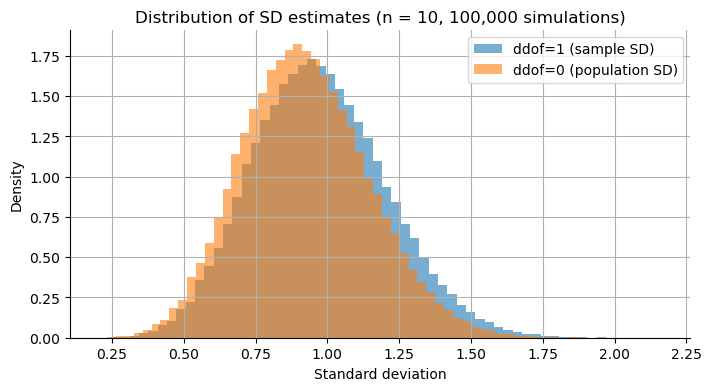

In [4]:
# --- Problem 2: Sample SD (ddof=1) vs Population SD (ddof=0) -------------------------------
# We quantify the difference between the sample SD and population SD estimators
# for many small samples drawn from N(0, 1).
#
# References:
# - numpy.std (ddof): https://numpy.org/doc/stable/reference/generated/numpy.std.html
# - Bessel’s correction: https://en.wikipedia.org/wiki/Bessel%27s_correction

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Fixed seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

def sds_from_normal(n_sims: int = 100_000, n: int = 10, seed: int = SEED):
    """
    Draw n_sims samples of size n from N(0,1) and compute two SD estimators.

    Returns
    -------
    sd_sample : np.ndarray
        Standard deviation with ddof=1 (sample SD, linked to unbiased variance).
    sd_pop : np.ndarray
        Standard deviation with ddof=0 (population SD / MLE under normality).
    """
    rng = np.random.default_rng(seed)

        # Each row is one sample of size n
    X = rng.normal(loc=0.0, scale=1.0, size=(n_sims, n))

    # ddof=1: sample SD (uses Bessel's correction for the variance)
    sd_sample = X.std(axis=1, ddof=1)

    # ddof=0: population SD (usual population formula)
    sd_pop = X.std(axis=1, ddof=0)

    return sd_sample, sd_pop

# Run the main experiment for n = 10
sd1, sd0 = sds_from_normal(n_sims=100_000, n=10)

# ---- Numerical summary ----
summary = pd.DataFrame({
    "Estimator": ["ddof=1 (sample SD)", "ddof=0 (population SD)"],
    "Mean": [sd1.mean(), sd0.mean()],
    "Std of estimator": [sd1.std(), sd0.std()],
    "Median": [np.median(sd1), np.median(sd0)],
})

display(summary.style.format({
    "Mean": "{:.4f}",
    "Std of estimator": "{:.4f}",
    "Median": "{:.4f}",
}))

# ---- Visual comparison: overlaid histograms ----
fig, ax = plt.subplots()

ax.hist(
    sd1,
    bins=60,
    density=True,
    alpha=0.6,
    label="ddof=1 (sample SD)",
)

ax.hist(
    sd0,
    bins=60,
    density=True,
    alpha=0.6,
    label="ddof=0 (population SD)",
)

ax.set_title("Distribution of SD estimates (n = 10, 100,000 simulations)")
ax.set_xlabel("Standard deviation")
ax.set_ylabel("Density")
ax.legend()
plt.show()

### Interpretation

From the **summary table** and overlapping histograms:

- With **n = 10**, the distribution for `ddof=1` tends to sit **slightly to the right** of the
  `ddof=0` distribution.  
  - This reflects that using `ddof=1` (Bessel’s correction) is designed to make the **variance**
    estimator unbiased, which also nudges the SD slightly upward for small samples.
- The `ddof=0` (population SD) estimator is slightly smaller on average in finite samples, but both
  estimators are **consistent**: as the sample size grows, they both concentrate near the true
  value \( \sigma = 1 \).

  **How does this change as n increases?**

- For small \( n \), the choice of `ddof` matters more — `ddof=1` corrects for the bias in the
  variance, and you see a slightly larger SD on average.
- As \( n \to \infty \), both estimators converge towards 1, and the difference between them
  becomes practically negligible.

In practice, for moderate and large samples the difference is tiny, but for **small** samples
using `ddof=1` is usually preferred when estimating a population SD from data.


## Problem 3 — t-Tests & Type II error (β)

## Problem 4 — ANOVA vs multiple t-tests